In [623]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

1)  Aqui vou tentar aplicar minha primeira ideia: 

    $x_i := $ valor medido no tempo i do retorno logaritmico daquele ativo


    $ E[X_t] = \frac{1}{N}\sum_{i= t-N}^{t-1}(x_i) = \overline{x}$


    $ \sigma_t^2 = \frac{1}{N-1}\sum_{i= t-N}^{t-1}(x_i - \overline{x})^2 $

    * Perceba que N é um hiperparâmetro

* Vamos aplicar essa estratégia para as seguintes criptos:

* Para o tempo de retorno, vamos escolher um período de x_days dias entre um trade e outro.

* Podemos adaptar esse período no futuro, encontrando um valor ótimo.

In [624]:
## Hiperparâmetros: 

N = 10  # intervalo de tempo para considerarmos a média
x_days = 7  # intervalo de dias que desejamos realizar as operações
SR = 0.01 # Vamos considerar que a nossa decisão de comprar ou não surgirá devido ao Sharpe Ratio

In [625]:
# Importando os dados da Bitcoin e da Etherium e então adicionando uma coluna que representa o retorno logaritmico 
# Além disso, vamos aplicar o método de resemple para agregar os valores em 7 e 7 dias

resample_period = f'{x_days}D'


symbol = 'BTC-USD'
start_date = '2010-01-01'
end_date = '2022-12-31'
data_BTC = yf.download(symbol, start=start_date, end=end_date)
data_BTC= data_BTC.resample(resample_period).agg({'Open': 'first', 'Close': 'last'})
#data_BTC['Total Return'] = data_BTC['Close'] / data_BTC['Open']
data_BTC['Log Return'] = (data_BTC['Close'] / data_BTC['Open']).apply(math.log)
data_BTC['Percentual Return'] = ((data_BTC['Close'] - data_BTC['Open'])/data_BTC['Open'])

symbol = 'ETH-USD'
start_date = '2010-01-01'
end_date = '2022-12-31'
data_ETH = yf.download(symbol, start=start_date, end=end_date)
data_ETH= data_ETH.resample(resample_period).agg({'Open': 'first', 'Close': 'last'})
#data_ETH['Total Return'] = data_ETH['Close'] / data_ETH['Open']
data_ETH['Log Return'] = (data_ETH['Close'] / data_ETH['Open']).apply(math.log)
data_ETH['Percentual Return'] = ((data_ETH['Close'] - data_ETH['Open'])/data_ETH['Open'])

data_BTC.head(), data_ETH.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(                  Open       Close  Log Return  Percentual Return
 Date                                                             
 2014-09-17  465.864014  435.790985   -0.066731          -0.064553
 2014-09-24  435.751007  386.944000   -0.118791          -0.112007
 2014-10-01  387.427002  336.187012   -0.141860          -0.132257
 2014-10-08  336.115997  400.869995    0.176181           0.192654
 2014-10-15  400.954987  386.475006   -0.036782          -0.036114,
                   Open       Close  Log Return  Percentual Return
 Date                                                             
 2017-11-09  308.644989  333.356995    0.077022           0.080066
 2017-11-16  333.442993  380.652008    0.132414           0.141580
 2017-11-23  381.438995  427.523010    0.114057           0.120816
 2017-11-30  431.214996  428.588013   -0.006111          -0.006092
 2017-12-07  426.368988  702.767029    0.499720           0.648260)

In [626]:
# Plotanto a descrição desses retornos
print("\nEtherium Log Return description:\n")
print(data_ETH['Log Return'].describe())
print("\nBitcoin Log Return description:\n")
print(data_BTC['Log Return'].describe())


Etherium Log Return description:

count    269.000000
mean       0.004985
std        0.141878
min       -0.528100
25%       -0.072372
50%        0.001114
75%        0.093972
max        0.499720
Name: Log Return, dtype: float64

Bitcoin Log Return description:

count    433.000000
mean       0.007990
std        0.102568
min       -0.414564
25%       -0.048057
50%        0.003094
75%        0.063353
max        0.378852
Name: Log Return, dtype: float64


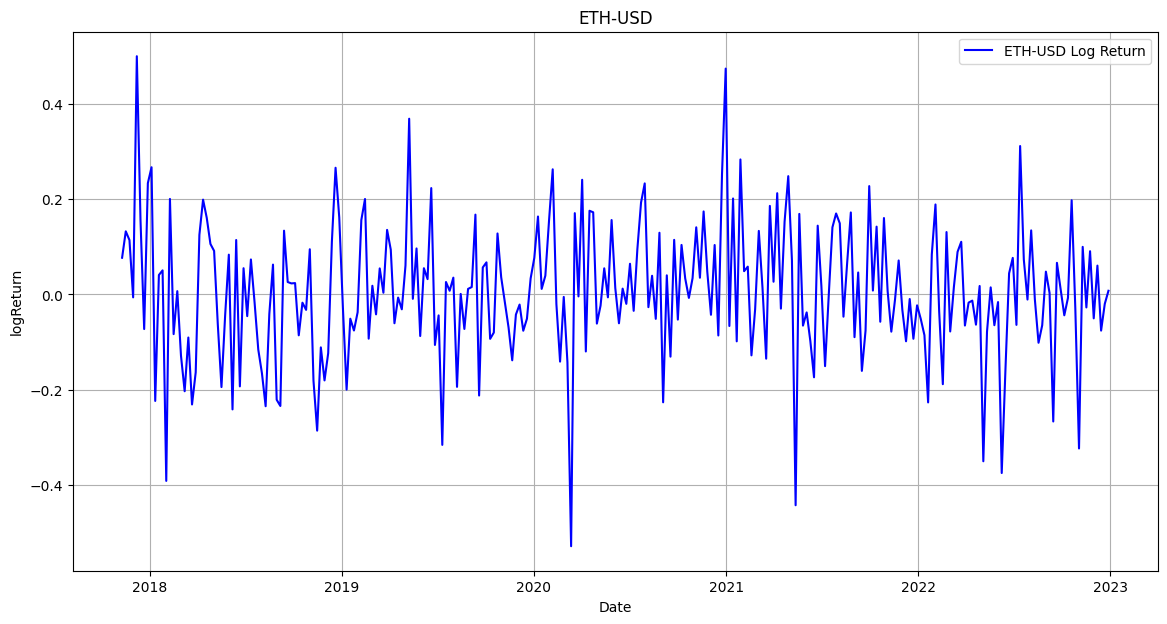

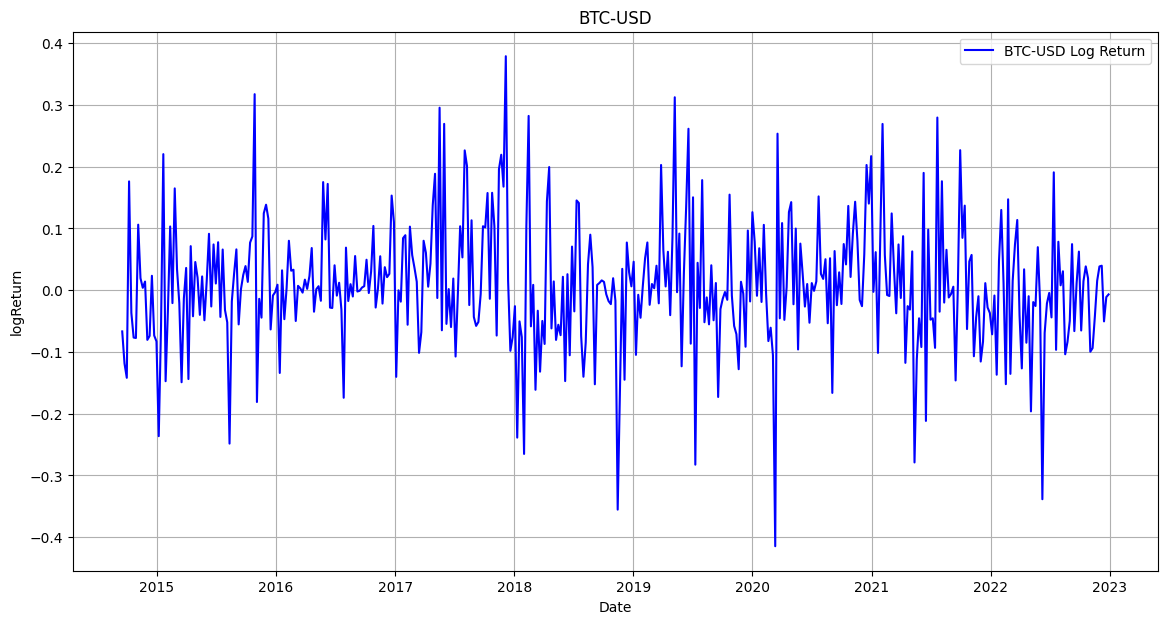

In [627]:
# Plotar o retorno logaritmo de ambos ao longo do tempo

plt.figure(figsize=(14, 7))
plt.plot(data_ETH['Log Return'], label='ETH-USD Log Return', color='blue')
plt.title('ETH-USD')
plt.xlabel('Date')
plt.ylabel('logReturn')
plt.grid(True)      
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data_BTC['Log Return'], label='BTC-USD Log Return', color='blue')
plt.title('BTC-USD')
plt.xlabel('Date')
plt.ylabel('logReturn')
plt.grid(True)      
plt.legend()
plt.show()

Vamos agora criar uma coluna que armazene o valor predito para aquele instante de tempo e o valor predito de seu desvio padrão.

In [628]:
# Criando a estratégia de compra


data_BTC['Predicted Value'] = data_BTC['Log Return'].rolling(window=N).mean().shift(1)
data_BTC['Predicted Risk'] = data_BTC['Log Return'].rolling(window=N).std().shift(1)
data_BTC['Sharpe Ratio'] = data_BTC['Predicted Value'] / data_BTC['Predicted Risk']
data_BTC['Erro'] = (data_BTC['Log Return'] - data_BTC['Predicted Value'])
data_BTC['Erro Absoluto'] = abs((data_BTC['Log Return'] - data_BTC['Predicted Value']))


data_BTC['Signal'] =  np.where(data_BTC['Sharpe Ratio'] > SR, 1, 0)
#   O Sharpe Ratio foi calculado apenas com valores de I_t-1, logo o signal é com base em informações de I_t-1
# basicamente, se o signal é 1 em uma certa linha, então teríamos comprado o ativo naquela semana.
data_BTC['Profit'] =  data_BTC['Percentual Return'] * data_BTC['Signal']

data_BTC.tail()
#data_BTC['Sharpe Ratio'].describe()


,Open,Close,Log Return,Percentual Return,Predicted Value,Predicted Risk,Sharpe Ratio,Erro,Erro Absoluto,Signal,Profit
Date,,,,,,,,,,,
2022-11-30,16445.476562,17089.503906,0.038414,0.039161,-0.013860,0.056920,-0.243507,0.052274,0.052274,0,0.0
2022-12-07,17089.505859,17781.318359,0.039684,0.040482,-0.011173,0.058854,-0.189843,0.050857,0.050857,0,0.0
2022-12-14,17782.066406,16906.304688,-0.050504,-0.049250,-0.013455,0.056056,-0.240029,-0.037049,0.037049,0,-0.0
2022-12-21,16904.527344,16717.173828,-0.011145,-0.011083,-0.011981,0.054720,-0.218946,0.000836,0.000836,0,-0.0
2022-12-28,16716.400391,16602.585938,-0.006832,-0.006809,-0.014563,0.053926,-0.270063,0.007731,0.007731,0,-0.0


In [629]:
# Plotanto a descrição desse profit
print("\nBitcoin Profit description:\n")
print(data_BTC['Profit'].describe())
print(data_BTC['Profit'].sum())


Bitcoin Profit description:

count    433.000000
mean       0.014078
std        0.082288
min       -0.339372
25%        0.000000
50%        0.000000
75%        0.012135
max        0.460607
Name: Profit, dtype: float64
6.09564192348766


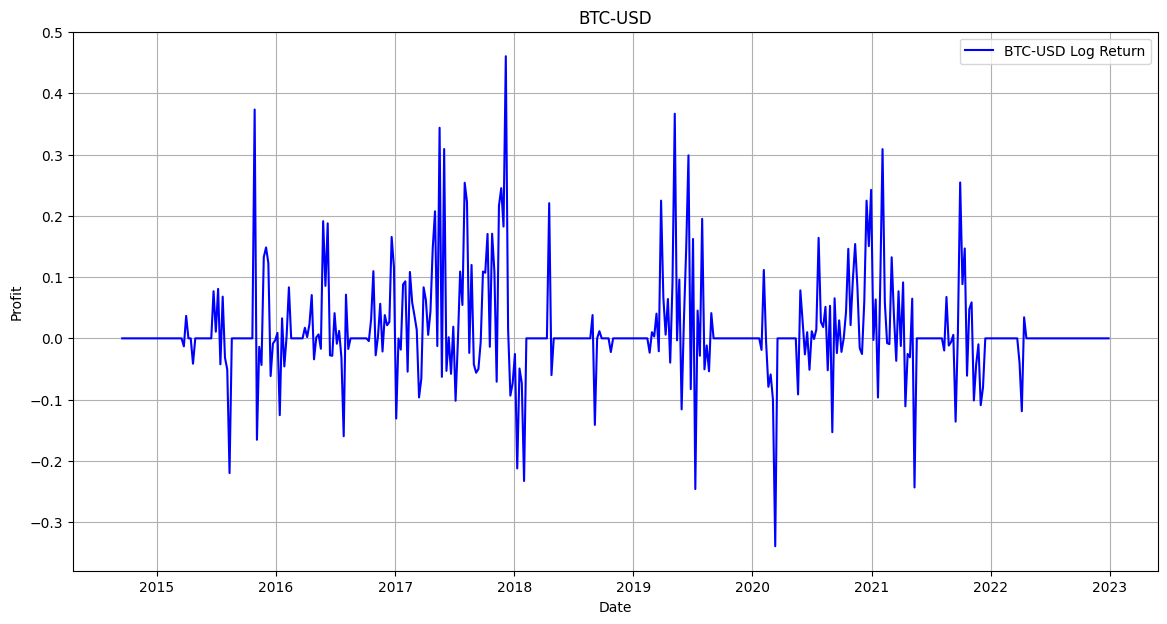

In [630]:
# Plotando o profit ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(data_BTC['Profit'], label='BTC-USD Log Return', color='blue')
plt.title('BTC-USD')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.grid(True)      
plt.legend()
plt.show()